# Capsule Network with Dynamic Routing (CapsNet) - PyTorch 1.4

In [1]:
import numpy as np
import torch 
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

### Visualizing Dataset

In [2]:
sample_data = MNIST('./mnist_data/', download=True, train=True)

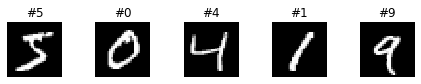

In [3]:
#show some samples
for i in range(5):
    
    sample = sample_data[i] #contain PIL images and corresponding labels.
    
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title("#{}".format(sample[1]))
    ax.axis('off')
    plt.imshow(sample[0], cmap='gray')

### CapsNet

In [4]:
batch_size           = 20
learning_rate        = 1e-3
epsilon              = 1e-9
height,width, depth  = 28,28,1
epoch                = 20
num_labels           = 10
primary_caps_vlength = 8
digit_caps_vlength   = 16
routing_iteration    = 3
m_plus               = 0.9
m_minus              = 0.1
lambda_              = 0.5
reg_scale            = 0.0005
device               = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def squash(capsules):
    '''
    Activation function for CapsNet.
    '''
    
    dot_prod      = torch.sum(capsules**2) #dot product
    scalar_factor = dot_prod/(1+dot_prod)/torch.sqrt(dot_prod+epsilon)
    squashed      = scalar_factor * capsules
    
    return squashed

In [6]:
def one_hot_encoder(labels, num_labels=num_labels):
    '''
    Convert the given integer batches to batches of one-hot encodings.
    '''
    
    one_hot = torch.zeros((labels.size(0), num_labels)).to(device)
    
    for i, label in enumerate(labels):
        one_hot[i][label.tolist()] = 1.0
    
    return one_hot

def margin_loss(v_lengths, y):
    '''
    Calculates the classification loss of the network.
    '''
    
    max_l = torch.max(torch.zeros(1).to(device), 0.9 - v_lengths)**2
    max_r = torch.max(torch.zeros(1).to(device), v_lengths - 0.1)**2
    
    max_l = max_l.view(y.size(0), -1)
    max_r = max_r.view(y.size(0), -1)
    
    T_c = y
    
    L_c = T_c * max_l + 0.5*(1-T_c)*max_r
    
    margin_loss = torch.mean(torch.sum(L_c, dim=1))
    
    return margin_loss

def reconstruction_loss(ori_imgs, decoded, reg_scale = reg_scale):
    
    origin = ori_imgs.view(ori_imgs.size(0), -1)
    
    recon_loss = reg_scale * nn.MSELoss()(origin, decoded)
    
    return recon_loss

In [7]:
class PrimaryCapsules(nn.Module):
    '''
    Converts the output from previously defined conv layers into capsules.
    '''
    
    def __init__(self, primary_caps_length=primary_caps_vlength):
        
        super(PrimaryCapsules, self).__init__()
        
        self.caps_length = primary_caps_length
    
    def forward(self, x):
        '''
        Transform the given feature vector to capsules and apply the squashing act. func.
        '''
        return squash(x.view(x.size(0), -1, self.caps_length))

In [8]:
class DigitCapsules(nn.Module):
    '''
    Uses the Primary Capsules for routing process and returns the output after the process.
    '''
    
    def __init__(self, num_capsules,
                       input_caps_length = primary_caps_vlength,
                       digit_caps_length = digit_caps_vlength, 
                       num_labels        = num_labels,
                       routing_iter      = routing_iteration,
                       device            = device):
        
        super(DigitCapsules, self).__init__()
        
        self.in_caps_length  = input_caps_length
        self.in_caps_num     = num_capsules
        self.out_caps_length = digit_caps_length
        self.out_caps_num    = num_labels
        self.routing_iter    = routing_iter
        
        #Initialize the weight and bias for the transformation of capsules later
        self.weight = nn.Parameter(0.1 * torch.randn(1, self.in_caps_num, self.out_caps_num, 
                                                     self.out_caps_length, self.in_caps_length))
        
        self.bias  = nn.Parameter(0.1 * torch.randn(1, 1, self.out_caps_num, self.out_caps_length, 1))
        
        self.device = device
        
        
    
    def forward(self, x):
        '''
        Perform the transformation of capsules + dynamic routing.
        '''
        #copy the weight [batch_size] times to perform batch operation.
        tiled_weights = self.weight.repeat(x.size(0), 1, 1, 1, 1) 
        #increase the dimension of the input capsules to perform batch multiplication.
        tiled_in_caps = x[:,:, None, :, None].repeat(1,1,self.out_caps_num, 1, 1)
        
        u_hat = torch.matmul(tiled_weights, tiled_in_caps).to(self.device)
        
        u_hat_detached = u_hat.detach() #no gradient flow
        
        b_ij = nn.Parameter(torch.zeros(x.size(0), x.size(1), self.out_caps_num, 1, 1), 
                            requires_grad=False).to(self.device) #coefficients for dynamic routing. No gradients.
        
        
        for r_iter in range(self.routing_iter):
            
            c_ij = nn.functional.softmax(b_ij, dim=2)
            
            if r_iter == self.routing_iter - 1: #final iteration
                
                s_j = torch.mul(c_ij, u_hat)
                
                s_j = torch.sum(s_j, dim=1, keepdim=True) + self.bias
                
                v_j = squash(s_j)
        
            else:
                
                s_j = torch.mul(c_ij, u_hat_detached)
                
                s_j = torch.sum(s_j, dim=1, keepdim=True) + self.bias
                
                v_j = squash(s_j)
                
                v_j_tiled = v_j.repeat(1, x.size(1), 1, 1, 1)
                
                product = u_hat_detached * v_j_tiled
                
                u_produce_v = torch.sum(product, dim=3, keepdim=True)
                
                b_ij = b_ij + u_produce_v
                
        return v_j

In [9]:
class ReconstructionNetwork(nn.Module):
    '''
    Used to reconstruct the image back from the final layer capsule.
    '''
    
    def __init__(self, num_labels        = num_labels,
                       final_capsule_num = digit_caps_vlength,
                       fc1_num           = 512,
                       fc2_num           = 1024,
                       img_height        = height,
                       img_width         = width,
                       img_depth         = depth):
        
        super(ReconstructionNetwork, self).__init__()
        
        self.num_labels       = num_labels
        self.input_neuron_num = self.num_labels*final_capsule_num
        self.fc1_out_num = fc1_num
        self.fc2_in_num  = fc1_num
        self.fc2_out_num = fc2_num
        self.fc3_in_num  = fc2_num
        self.output_size = img_height*img_width*depth
        
        self.fc_layers = nn.Sequential(
                                    nn.Linear(self.input_neuron_num, self.fc1_out_num),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(self.fc2_in_num, self.fc2_out_num),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(self.fc3_in_num, self.output_size),
                                    nn.Sigmoid()
                                    )
        
    def forward(self, x, y):
        masked_capsule = torch.squeeze(x, dim=-1) * y.view(-1, self.num_labels, 1)
        capsule_reshaped = masked_capsule.view(x.size(0), self.input_neuron_num)
        
        decoded = self.fc_layers(capsule_reshaped)
        
        return decoded

**CapsNet Model**

In [10]:
class CapsuleNetwork(nn.Module):
    '''
    Entire Capsule Network that make use of PrimaryCapsules and DigitCapsules classes above.
    '''
    
    def __init__(self, conv1_output_depth = 256, 
                       conv2_output_depth = 256, 
                       kernel_size_1      = 9,
                       kernel_size_2      = 9,
                       padding_1          = 0,
                       padding_2          = 0,
                       stride_1           = 1,
                       stride_2           = 2,
                       in_channel         = depth):
        
        super(CapsuleNetwork, self).__init__()
        
        #Convolutional layers
        self.cnn_blocks = nn.Sequential(
                                        nn.Conv2d(1, conv1_output_depth, kernel_size=kernel_size_1, 
                                                  padding=padding_1, stride=stride_1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(conv1_output_depth, conv2_output_depth, 
                                                  kernel_size=kernel_size_2, 
                                                  padding=padding_2, stride=stride_2)
                                        )
        self.primary_caps = PrimaryCapsules() #init primary caps class
        self.digit_caps   = DigitCapsules(num_capsules=1152) #init digit caps class
        self.recon_net    = ReconstructionNetwork()
        
    
    def forward(self, x, y):
        
        conv_outputs       = self.cnn_blocks(x)
        primary_caps_layer = self.primary_caps(conv_outputs)
        digit_caps_layer   = self.digit_caps(primary_caps_layer)
        
        digits = torch.squeeze(digit_caps_layer, dim=1)
        
        v_lengths = digits.norm(dim = 2)
        
        one_hot_y = one_hot_encoder(y)
        
        classification_loss = margin_loss(v_lengths, one_hot_y)
        
        decoded = self.recon_net(digits, one_hot_y)
        
        recon_loss = reconstruction_loss(x, decoded)
        
        total_loss = classification_loss + recon_loss
        
        return (total_loss, v_lengths, decoded)

        
caps_model = CapsuleNetwork().to(device)
optimizer = Adam(caps_model.parameters(), lr=1e-4)
print(caps_model)

CapsuleNetwork(
  (cnn_blocks): Sequential(
    (0): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (primary_caps): PrimaryCapsules()
  (digit_caps): DigitCapsules()
  (recon_net): ReconstructionNetwork(
    (fc_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


### Model Training

In [11]:
mnist_data = MNIST('./mnist_data/', download=True, transform=transforms.ToTensor())
mnist_dataloader = DataLoader(mnist_data, batch_size=1, shuffle=False, num_workers=4)

In [13]:
for epoch_iter in range(10):

    total_loss = 0
    for i, sample in enumerate(mnist_dataloader):

        out = caps_model(sample[0].cuda(), sample[1].cuda())
        
        optimizer.zero_grad()
        loss = out[0]
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        if i == 5:
            break
    
    print(total_loss)

0.9108177572488785
0.826164722442627
0.7593359351158142
0.709135890007019
0.6703215166926384
0.6402557864785194
0.6189927235245705
0.6084759384393692
0.600558802485466
0.6040965914726257
